# Import libraries

In [29]:
import numpy as np
import pandas as pd
import re,nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# load data

In [ ]:
train_url = "https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/train_150k.txt"
test_url = "https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/test_62k.txt"

df_train = pd.read_csv(train_url, sep="\t", header=None, names=["feeling", "text"])
df_test = pd.read_csv(test_url, sep="\t", header=None, names=["feeling", "text"])


In [ ]:
df_train.head(5)

,feeling,text
0,0,Starting back at work today Looks like it'l...
1,1,Sugar levels dropping... munchies setting in. ...
2,1,@karineb22 yeah!!! have a great summer break!
3,1,hannah montana was very good. now going to re...
4,1,"@Mayra326 aww, have fun! I just had my 3D las..."


In [ ]:
df_test.head(5)

,feeling,text
0,1,@justineville ...yeahhh. ) i'm 39 tweets from ...
1,0,@ApplesnFeathers aww. Poor baby! On your only ...
2,0,@joeymcintyre With my refunded $225 (Australia...
3,0,It's fine. Today sucks just because me those t...
4,0,"Im just chilling on psp and stuff, but sitting..."


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   feeling  149985 non-null  int64 
 1   text     149985 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


# Data cleaning

In [ ]:
df_train.isnull().sum()

,0
feeling,0
text,0


In [ ]:
df_test.isnull().sum()

,0
feeling,0
text,0


In [ ]:
df_train.duplicated().sum()

np.int64(0)

In [ ]:
df_test.duplicated().sum()

np.int64(0)

# Data analysis

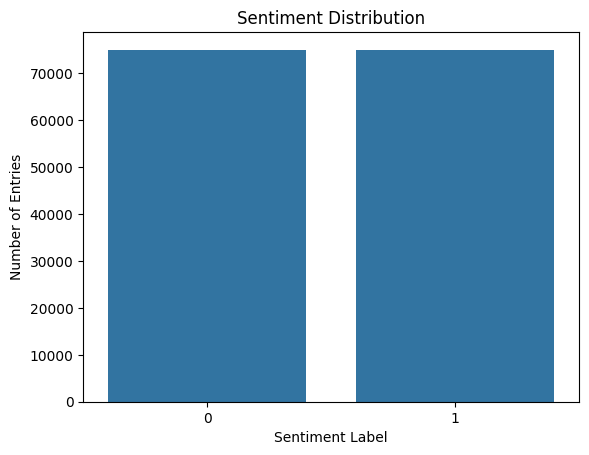

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='feeling', data=df_train)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Entries')
plt.show()


In [ ]:
df_train['text_length'] = df_train['text'].apply(len)
print(df_train[['text', 'text_length']].head())

                                                text  text_length
0  Starting  back at work today   Looks like it'l...           87
1  Sugar levels dropping... munchies setting in. ...          103
2     @karineb22 yeah!!! have a great summer break!            46
3  hannah montana was very good.  now going to re...           59
4  @Mayra326 aww, have fun!  I just had my 3D las...           53


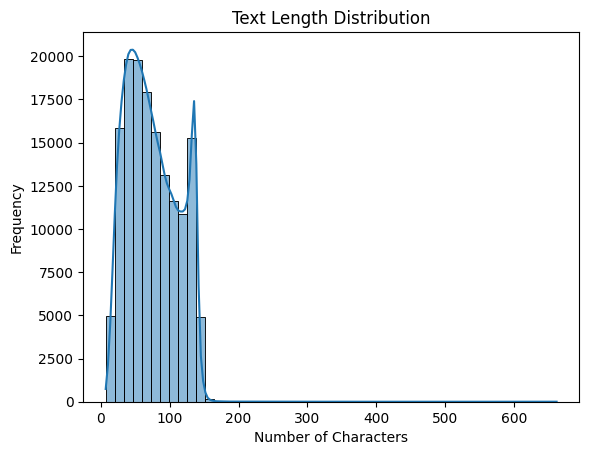

In [ ]:
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


In [ ]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
print(df_train[['text', 'word_count']].head())

                                                text  word_count
0  Starting  back at work today   Looks like it'l...          16
1  Sugar levels dropping... munchies setting in. ...          16
2     @karineb22 yeah!!! have a great summer break!            7
3  hannah montana was very good.  now going to re...          10
4  @Mayra326 aww, have fun!  I just had my 3D las...          11


In [ ]:
from collections import Counter
import re

def clean_text(text):
    return re.sub(r'[^A-Za-z\s]', '', text.lower())

for label in df_train['feeling'].unique():
    texts = ' '.join(df_train[df_train['feeling'] == label]['text'])
    cleaned = clean_text(texts)
    word_counts = Counter(cleaned.split()).most_common(10)
    print(f"\nTop words for label {label}:")
    print(word_counts)


Top words for label 0:
[('i', 43662), ('to', 29419), ('the', 24251), ('my', 18037), ('a', 17313), ('and', 14419), ('is', 12043), ('it', 11289), ('in', 10816), ('im', 9746)]

Top words for label 1:
[('i', 27555), ('the', 24873), ('to', 23544), ('a', 18731), ('you', 16457), ('and', 13901), ('my', 11899), ('for', 11053), ('it', 10643), ('is', 10180)]


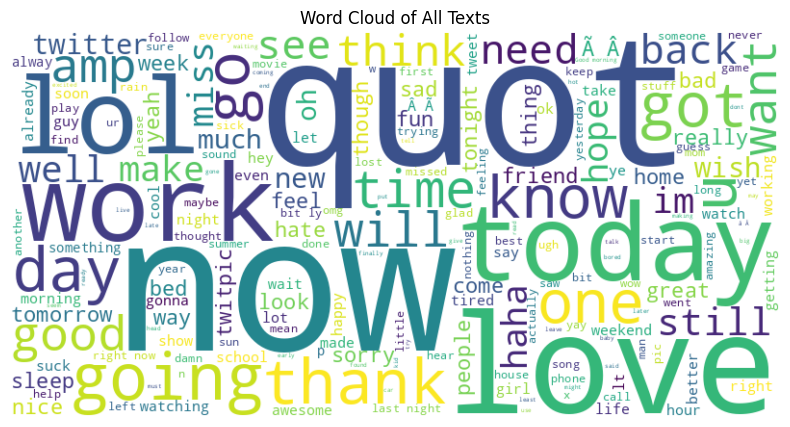

In [ ]:
from wordcloud import WordCloud

all_text = ' '.join(df_train['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Texts')
plt.show()

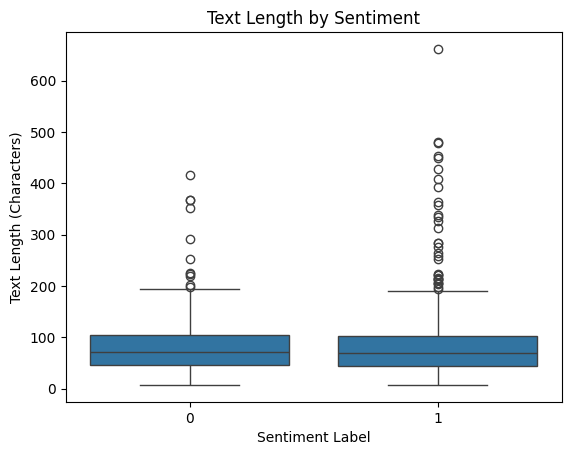

In [ ]:
sns.boxplot(x='feeling', y='text_length', data=df_train)
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment Label')
plt.ylabel('Text Length (Characters)')
plt.show()

# Data processing for neural networks

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   feeling      149985 non-null  int64 
 1   text         149985 non-null  object
 2   text_length  149985 non-null  int64 
 3   word_count   149985 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.6+ MB


In [ ]:
df_train.drop(columns=['text_length', 'word_count'], inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   feeling  149985 non-null  int64 
 1   text     149985 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df_train['clean_text']
y = df_train['feeling']

X_train, X_test , y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')


# Building a neural network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.5, recurrent_dropout=0.2)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1410s 1s/step - accuracy: 0.7006 - loss: 0.5832 - val_accuracy: 0.7868 - val_loss: 0.4578
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1359s 1s/step - accuracy: 0.8043 - loss: 0.4349 - val_accuracy: 0.7908 - val_loss: 0.4465
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1366s 1s/step - accuracy: 0.8194 - loss: 0.4017 - val_accuracy: 0.7940 - val_loss: 0.4495
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1411s 1s/step - accuracy: 0.8307 - loss: 0.3816 - val_accuracy: 0.7939 - val_loss: 0.4591
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 88ms/step


In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on test set: {accuracy:.4f}")


Accuracy on test set: 0.7908


In [30]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     15004
           1       0.80      0.77      0.79     14993

    accuracy                           0.79     29997
   macro avg       0.79      0.79      0.79     29997
weighted avg       0.79      0.79      0.79     29997



# Transformer

In [36]:
!pip install -q transformers
!pip install -q torch

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

In [38]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    max_length=128,
    device=0 if torch.cuda.is_available() else -1
)

Device set to use cpu


In [35]:
subset_texts = df_test['clean_text'].iloc[:7].tolist()
results = sentiment_pipeline(subset_texts, batch_size=32)

binary_labels = []
confidences = []

for result in results:
    label = result['label']
    score = result['score']

    if label == 'LABEL_2':
        binary_labels.append(1)
        confidences.append(score)
    elif label == 'LABEL_0':
        binary_labels.append(0)
        confidences.append(score)
    else:
        binary_labels.append(None)
        confidences.append(score)

df_test_subset = df_test.iloc[:7].copy()
df_test_subset['binary_label'] = binary_labels
df_test_subset['confidence'] = confidences

df_test_subset_clean = df_test_subset.dropna(subset=['binary_label']).reset_index(drop=True)


print(df_test_subset_clean[['clean_text', 'binary_label', 'confidence']])


                                          clean_text  binary_label  confidence
0  applesnfeathers aww poor baby on your only rea...           0.0    0.627816
1  joeymcintyre with my refunded australian ticke...           1.0    0.547288
2  its fine today sucks just because me those thi...           0.0    0.586156
3  lisarinna very sad lisashe is freeeeeeeeeeee a...           1.0    0.795259
